
![Pokemon Logo - Nintendo/The Pokemon Company](img/International_Pokémon_logo.svg)
## *_MongoDB Personal Project:_*
# **___PokeMongoDB___**
# A Biological/Environmental Deep Dive into the World of Pokemon

## Intro
For the purposes of this project, I chose to use the PokeApi API endpoints to download data into a local MongoDB instance. With this data, the plan is to dive in and find different features about the world of pokemon, different features in different regions, and take a look at an overview of all the Pokemon monsters that have been released.

First, we need to set up the database to have it ready to accept the data to be requested from the API.

In [4]:
import os, json, time, requests, datetime as dt
from dotenv import load_dotenv, find_dotenv
from pymongo import MongoClient, ASCENDING

# 1 - config 
load_dotenv(find_dotenv(usecwd=True))
MONGO_URI = os.getenv("MONGO_URI")
DB_NAME = os.getenv("DB_NAME")

# 2 - connect to MongoDB and ping
client = MongoClient(MONGO_URI, serverSelectionTimeoutMS=5000)
client.admin.command('ping')

# 3 - db handle
db = client[DB_NAME]

# 4 - create collections with indexes
species_raw = db["species_raw"]
species_clean = db["species_clean"]
pokemon_raw = db["pokemon_raw"]
pokemon_clean = db["pokemon_clean"]

#5 - create collections by creating minimal indexes
species_raw.create_index([("external_id", ASCENDING)], unique=True)
species_clean.create_index([("name", ASCENDING)], unique=True)
pokemon_raw.create_index([("external_id", ASCENDING)], unique=True)
pokemon_clean.create_index([("name", ASCENDING)], unique=True)

print("Connected to DB: ", DB_NAME)
print("Collections initialized: ", db.list_collection_names())


Connected to DB:  pokeapi_project
Collections initialized:  ['pokemon_clean', 'species_clean', 'pokemon_raw', 'species_raw']


![Database Created](img/pokeapi_created.png)

>As we can see now in `Mongo DB Compass`, the database has been created as well as the different collections we will use. 

Before bulk-loading anything, we will fetch one species to understand the JSON shape and decide what fields we'll keep later in the clean collection. The endpoint we will target first for this is the `Pokemon Species` endpoint at `https://pokeapi.co/api/v2/pokemon-species/`. We'll use species number 413, called `wormadam`, as that is the example given in the API documentation, so that we may quickly recognize any error. Once we retrieve that information, we will print a human-readable summary of key attributes we are interested in.

In [6]:
import requests, json

BASE = "https://pokeapi.co/api/v2/"

def get_species (id_or_name):
    """Fetches a Pokemon species by ID or name from the PokeAPI."""
    r = requests.get(f"{BASE}pokemon-species/{id_or_name}", timeout=30)
    r.raise_for_status()
    return r.json()

def pick_en(entries, value_key):
    """Picks the English entry from a list of localized entries."""
    for entry in entries:
        if (entry.get("language") or {}).get("name") == "en":
            return entry.get(value_key)
    return None

# Fetch species with ID 413 (wormadam)
sp = get_species(413)

# summarize key fields we might normalize later
summary = {
    "id": sp.get("id"),
    "name": sp.get("name"),
    "order": sp.get("order"),
    "is_baby": sp.get("is_baby"),
    "is_legendary": sp.get("is_legendary"),
    "is_mythical": sp.get("is_mythical"),
    "gender_rate": sp.get("gender_rate"),
    "capture_rate": sp.get("capture_rate"),
    "base_happiness": sp.get("base_happiness"),
    "hatch_counter": sp.get("hatch_counter"),
    "forms_switchable": sp.get("forms_switchable"),
    "growth_rate": (sp.get("growth_rate") or {}).get("name"),
    "color": (sp.get("color") or {}).get("name"),
    "shape": (sp.get("shape") or {}).get("name"),
    "habitat": (sp.get("habitat") or {}).get("name"),
    "generation": (sp.get("generation") or {}).get("name"),
    "evolves_from_species": (sp.get("evolves_from_species") or {}).get("name"),
    "evolution_chain_id": (lambda url: int(url.rstrip('/').split('/')[-1]) if url else None)(
        (sp.get("evolution_chain") or {}).get("url")
    ),
    "egg_groups": [eg.get("name") for eg in (sp.get("egg_groups") or [])],
    "genus_en": pick_en(sp.get("genera"), "genus"),
    "flavor_text_en": (pick_en(sp.get("flavor_text_entries"), "flavor_text") or "")
                        .replace("\n", " ").replace("\f", " ").strip(),
}

print(f"=== pokemon-species summary (id = {summary["id"]}) ===")
print(json.dumps(summary, indent=2))

print("\n === pokemon-species raw JSON preview ===")
print(json.dumps(sp, indent=2)[:2000] + "\n...")

=== pokemon-species summary (id = 413) ===
{
  "id": 413,
  "name": "wormadam",
  "order": 441,
  "is_baby": false,
  "is_legendary": false,
  "is_mythical": false,
  "gender_rate": 8,
  "capture_rate": 45,
  "base_happiness": 70,
  "hatch_counter": 15,
  "forms_switchable": false,
  "growth_rate": "medium",
  "color": "green",
  "shape": "blob",
  "habitat": null,
  "generation": "generation-iv",
  "evolves_from_species": "burmy",
  "evolution_chain_id": 213,
  "egg_groups": [
    "bug"
  ],
  "genus_en": "Bagworm Pok\u00e9mon",
  "flavor_text_en": "When BURMY evolved, its cloak became a part of this Pok\u00e9mon\u2019s body. The cloak is never shed."
}

 === pokemon-species raw JSON preview ===
{
  "base_happiness": 70,
  "capture_rate": 45,
  "color": {
    "name": "green",
    "url": "https://pokeapi.co/api/v2/pokemon-color/5/"
  },
  "egg_groups": [
    {
      "name": "bug",
      "url": "https://pokeapi.co/api/v2/egg-group/3/"
    }
  ],
  "evolution_chain": {
    "url": "https:

> Output looks good, so next we'll make sure that the raw JSON output lands into MongoDB as the first record of the staging collection.

## Next Step
We'll create a raw landing collection where we store each API response as it is returned. This will let us re-run transformations without recalling the API, freeing up traffic for other users.

In the following cell we will:
- Add two "housekeeping" fields: `external_id` which will be the species' numeric id (413 in this case), and `_fetchedAt`, a timestamp.
- Upsert by `external_id` so rer-runs don't duplicate
- Confirm the insert by showing the collection count and a tiny projection of the stored doc

In [7]:
import datetime as dt

assert "db" in globals(), "Connect to MongoDB first"
assert "sp" in globals(), "Run the previous cell to fetch species first"

species_raw = db["species_raw"]

doc = dict(sp)  # make a copy
doc["external_id"] = int(sp["id"])
doc["_fetchedAt"] = dt.datetime.now()

# upsert by external_id
res = species_raw.update_one(
    {"external_id": doc["external_id"]},
    {"$set": doc},
    upsert=True
)

print("Upsert acknowledged:", res.acknowledged)
print("species_raw count:", species_raw.count_documents({}))

# show a projection to confirm
print(species_raw.find_one(
    {"external_id": doc["external_id"]},
    {"_id": 0, "external_id": 1, "name": 1, "growth_rate.name": 1}
))


Upsert acknowledged: True
species_raw count: 1
{'external_id': 413, 'growth_rate': {'name': 'medium'}, 'name': 'wormadam'}


Next up we want to bulk load all pokemon species into `species_raw` in order to populate our staging collection with every species document so we can transform localy without contacting the API again. Our approach will be to use the `paged-list` endpoint on `pokeapi.co` to discover all species, then follow each item's url to fetch the full document for each species. Since we're implementing an upsert safety measure, we'll be able to skip already present docs (wormadam) so we can resume or re-run this block safely. We will also allow a small sleep between requests to be nice to the public API.

In [8]:
import time, requests, datetime as dt

assert "db" in globals(), "Connect to MongoDB first"

species_raw = db["species_raw"]
BASE = "https://pokeapi.co/api/v2/"

def list_species (limit=200, offset=0):
    """Lists Pokemon species with pagination."""
    r = requests.get(f"{BASE}pokemon-species", params={"limit": limit, "offset": offset}, timeout=30)
    r.raise_for_status()
    return r.json()

# discover total species count and ids for resuming
meta = list_species(limit=1, offset=0)
total = meta["count"]
existing = {d["external_id"] for d in species_raw.find({}, {"external_id": 1})}

print(f"Total species supported by API: {total}")
print(f"Already iun species_raw: {len(existing)}")

inserted = 0
page = 100
for offset in range(0, total, page):
    page_data = list_species(limit=page, offset=offset)
    for item in page_data["results"]:
        url = item["url"]
        # fetch full species count
        doc = requests.get(url, timeout=30).json()
        sid = int(doc["id"])
        if sid in existing:
            continue
        doc["external_id"] = sid
        doc["_fetchedAt"] = dt.datetime.now()
        species_raw.update_one({"external_id": sid}, {"$set": doc}, upsert=True)
        inserted += 1
        time.sleep(0.05)  # be nice to the public API
    print(f"Progress: {min(offset + page, total)}/{total} species, {inserted} new inserted")

print("species_raw total documents:", species_raw.count_documents({}))

Total species supported by API: 1025
Already iun species_raw: 1
Progress: 100/1025 species, 100 new inserted
Progress: 200/1025 species, 200 new inserted
Progress: 300/1025 species, 300 new inserted
Progress: 400/1025 species, 400 new inserted
Progress: 500/1025 species, 499 new inserted
Progress: 600/1025 species, 599 new inserted
Progress: 700/1025 species, 699 new inserted
Progress: 800/1025 species, 799 new inserted
Progress: 900/1025 species, 899 new inserted
Progress: 1000/1025 species, 999 new inserted
Progress: 1025/1025 species, 1024 new inserted
species_raw total documents: 1025


>All the existing species available on `pokeapi.co` have been stored locally in `species_raw`, which means we are ready to create a clean, analysis-friendly collection (`species_clean`) by extracting the fiuelds we care about.

## Transformation
The next step, as previously stated, is transforming the data from `species_raw` to `species_clean`. We want flat, queryable documents, and we only want to keep the fields we mean to analyze, such as taxonomy, flags, rates, lineage, and only the selected English texts for each. We want one document per species, with simple scalar fields and small arrays, and we want them to be flat for easier querying and plotting, as well as migration later on or enriching the data with lookups from other endpoints. So next we will:
- Read all docs from species_raw
- Extract fields (`growth_rate.name`, `habitat.name`, `genus`, `flavor_text`)
- Write to `species_clean` with `_id = id` for stability
- Add helpful indexes for common analysis

In [11]:
import datetime as dt

assert "db" in globals(), "Connect to MongoDB first"

species_raw = db["species_raw"]
species_clean = db["species_clean"]

def get_en(items, value_key):
    """Gets the English entry from a list of localized entries."""
    for it in items or []:
        if (it.get("language") or {}).get("name") == "en":
            return it.get(value_key)
    return None

def parse_chain_id(url):
    """Extracts the evolution chain ID from a URL. Some Pokemon don't have an evolution chain."""
    if not url:
        return None
    try:
        return int(url.rstrip('/').split('/')[-1])
    except:
        return None
    
species_clean.drop()

bulk = []
cursor = species_raw.find({}, {"_id":0})
for s in cursor:
    doc = {
        "_id": int(s["id"]),
        "id": int(s["id"]),
        "name": s.get("name"),
        "genus_en": get_en(s.get("genera"), "genus"),
        "flavor_text_en": (get_en(s.get("flavor_text_entries"), "flavor_text") or "")
                            .replace("\n", " ").replace("\f", " ").strip(),

        # flags
        "is_baby": bool(s.get("is_baby")),
        "is_legendary": bool(s.get("is_legendary")),
        "is_mythical": bool(s.get("is_mythical")),
        "is_default": bool(s.get("is_default")),

        # numeric attributes
        "gender_rate": s.get("gender_rate"),
        "capture_rate": s.get("capture_rate"),
        "base_happiness": s.get("base_happiness"),
        "hatch_counter": s.get("hatch_counter"),
        "forms_switchable": bool(s.get("forms_switchable")),

        # taxonomy (flattened as strings)
        "growth_rate": (s.get("growth_rate") or {}).get("name"),
        "color":       (s.get("color") or {}).get("name"),
        "habitat":     (s.get("habitat") or {}).get("name"),
        "shape":       (s.get("shape") or {}).get("name"),
        "generation":  (s.get("generation") or {}).get("name"),

        # lineage
        "evolves_from_species": (s.get("evolves_from_species") or {}).get("name"),
        "evolution_chain_id": parse_chain_id((s.get("evolution_chain") or {}).get("url")),

        # small arrays
        "egg_groups": [eg.get("name") for eg in (s.get("egg_groups") or [])],

        "_updatedAt": dt.datetime.now(),
    }
    bulk.append(doc)

if bulk:
    species_clean.insert_many(bulk, ordered=False)

# helpful indexes
species_clean.create_index([("name", 1)], unique=True)
species_clean.create_index([("habitat", 1)])
species_clean.create_index([("generation", 1)])
species_clean.create_index([("color", 1)])
species_clean.create_index([("growth_rate", 1)])

print("species_clean count: ", species_clean.count_documents({}))
print("example:\n", species_clean.find_one({}, {"_id":0, "id":1, "name":1, "habitat":1, "generation":1, "flavor_text_en":1, "egg_groups":1}))

species_clean count:  1025
example:
 {'id': 413, 'name': 'wormadam', 'flavor_text_en': 'When BURMY evolved, its cloak became a part of this Pokémon’s body. The cloak is never shed.', 'habitat': None, 'generation': 'generation-iv', 'egg_groups': ['bug']}


![species_clean populated](img/species_clean_populated.png)
>As we can see above from Compass, species_clean has been populated.

We are now ready to gather data from a second endpoint, `pokemon`, to enrich our study. This endpoint will give us height, weight, base_experience, types, abilities, and sprite data. We'll stage a raw JSON into `pokemon_raw`, just we did before, before building a clean `pokemon_clean` collection and link it to `species_clean`.

We will be following the exact same process as before for this endpoint.

In [12]:
import datetime as dt

pokemon_raw = db["pokemon_raw"]

def list_pokemon (limit=200, offset=0):
    """Return a page of pokemon metadata from /pokemon endpoint."""
    return requests.get(f"{BASE}pokemon", params={"limit": limit, "offset": offset}, timeout=30).json()

meta = list_pokemon(limit=1)
total = meta["count"]
existing = {d["external_id"] for d in pokemon_raw.find({}, {"external_id": 1})}

print(f"Total pokemon supported by API: {total}")
print(f"Already in pokemon_raw: {len(existing)}")

inserted = 0
page = 100
for offset in range(0, total, page):
    page_data = list_pokemon(limit=page, offset=offset)
    for item in page_data["results"]:
        detail = requests.get(item["url"], timeout=30).json()
        pid = int(detail["id"])
        if pid in existing:
            continue
        detail["external_id"] = pid
        detail["_fetchedAt"] = dt.datetime.now()
        pokemon_raw.update_one({"external_id": pid}, {"$set": detail}, upsert=True)
        inserted += 1
        time.sleep(0.05)
    print(f"Progress: {min(offset + page, total)}/{total} pokemon, {inserted} new inserted")

print("pokemon_raw total documents:", pokemon_raw.count_documents({}))

Total pokemon supported by API: 1328
Already in pokemon_raw: 0
Progress: 100/1328 pokemon, 100 new inserted
Progress: 200/1328 pokemon, 200 new inserted
Progress: 300/1328 pokemon, 300 new inserted
Progress: 400/1328 pokemon, 400 new inserted
Progress: 500/1328 pokemon, 500 new inserted
Progress: 600/1328 pokemon, 600 new inserted
Progress: 700/1328 pokemon, 700 new inserted
Progress: 800/1328 pokemon, 800 new inserted
Progress: 900/1328 pokemon, 900 new inserted
Progress: 1000/1328 pokemon, 1000 new inserted
Progress: 1100/1328 pokemon, 1100 new inserted
Progress: 1200/1328 pokemon, 1200 new inserted
Progress: 1300/1328 pokemon, 1300 new inserted
Progress: 1328/1328 pokemon, 1328 new inserted
pokemon_raw total documents: 1328


>After downloading the data, once again we aim to transform the raw output and store it, migrating from `pokemon_raw` to `pokemon_clean`. Each pokemon will contain the following:
- Basic info: `id`, `name`, `height`, `weight`, `base_experience`
- Categorical info: `primary_type`, list of all `types`
- Stats (stored as key-value map): `{"speed": 35, "attack": 45, ...}`
- Sprite URLs (front and official artwork)
- Species name (used to link with `species_clean`)
This flattened form is what we'll use for joins, aggregations, and visualizations.

In [14]:
from pymongo import ASCENDING
import datetime as dt

pokemon_clean = db["pokemon_clean"]
pokemon_raw  = db["pokemon_raw"]

pokemon_clean.drop()

bulk = []

for p in pokemon_raw.find({}, {"_id":0}):
    types = [t["type"]["name"] for t in (p.get("types") or [])]
    stats_map = { s["stat"]["name"]: s["base_stat"] for s in (p.get("stats") or []) }
    sprites = {
        "front_default": p.get("sprites", {}).get("front_default"),
        "official_artwork": p.get("sprites", {}).get("other", {}).get("official-artwork", {}).get("front_default"),
    }
    out = {
        "_id": int(p["id"]),
        "id": int(p["id"]),
        "name": p.get("name"),
        "is_default": bool(p.get("is_default")),
        "height": p.get("height"),
        "weight": p.get("weight"),
        "base_experience": p.get("base_experience"),
        "types": types,
        "primary_type": types[0] if types else None,
        "abilities": [a["ability"]["name"] for a in (p.get("abilities") or [])],
        "moves_count": len(p.get("moves") or []),
        "stats": stats_map,
        "sprites": sprites,
        "species_name": (p.get("species") or {}).get("name"),
        "_updatedAt": dt.datetime.now(),
    }
    bulk.append(out)

if bulk:
    pokemon_clean.insert_many(bulk, ordered=False)
    pokemon_clean.create_index([("name", ASCENDING)], unique=True)
    pokemon_clean.create_index([("primary_type", ASCENDING)])
    pokemon_clean.create_index([("species_name", ASCENDING)])

print("pokemon_clean count: ", pokemon_clean.count_documents({}))
print("example:\n", pokemon_clean.find_one({}, {"_id":0, "id":1, "name":1, "primary_type":1, "height":1, "weight":1}))

pokemon_clean count:  1328
example:
 {'id': 1, 'name': 'bulbasaur', 'height': 7, 'weight': 69, 'primary_type': 'grass'}


![pokemon_clean populated](img/pokemon_clean_populated.png)
>pokemon_clean is now populated as well, which concludes the data collection part of this project.

We now have four collections, two of which are raw outputs and can still be used to transform into other collections, and two which we have cleaned for analysis. Next up, we will run a MongoDB aggregation that joins Pokemon with their corresponding species info (using `$lookup`) in order to explore trends, like average weight by habitat or generation.

## Aggregation
This step looks to combine `pokemon_clean` and `species_clean` using MongoDB's `$lookup`. We want to perform a cross-collection analysis by linking Pokemon to their species metadata. We will be joining on `pokemon_clean.species_name` with `species_clean.name`. As a first analysis we'll take a look at the average weight by habitat, which should help reveal if Pokemon found in certain environments tend to be heavier or lighter.

In [15]:
import pandas as pd

pipeline = [
    {"$lookup": {
        "from": "species_clean",
        "localField": "species_name",
        "foreignField": "name",
        "as": "species_info"
    }},
    {"$unwind": "$species_info"},
    {"$group": {
        "_id": "$species_info.habitat",
        "avg_weight": {"$avg": "$weight"},
        "avg_height": {"$avg": "$height"},
        "count": {"$sum": 1}
    }},
    {"$sort": {"avg_weight": -1}}
]

result = list(db["pokemon_clean"].aggregate(pipeline))
df = pd.DataFrame(result).rename(columns={"_id": "habitat"})
print(df.head())

         habitat   avg_weight  avg_height  count
0  rough-terrain  1557.588235   13.235294     34
1       mountain  1391.274194   25.483871     62
2           cave  1294.729730   22.837838     37
3           None  1065.825123   21.831281    812
4           rare   995.157895   26.789474     19


>With this first glance we have a little bit of insight. It seems rokcy terrain like `rough-terrain` and `mountain` habitats tend to create heavier pokemon. Let's visualize this further for a clearer picture.

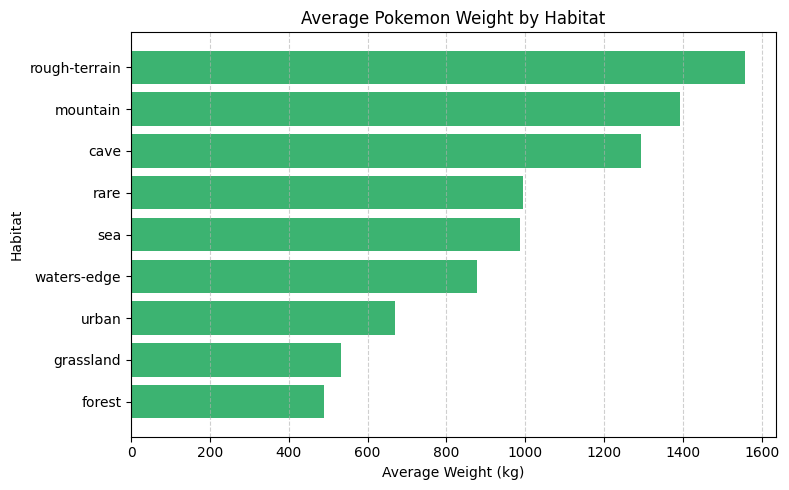

In [18]:
import matplotlib.pyplot as plt

plot_df = df.dropna(subset=["habitat"]).sort_values("avg_weight", ascending=True)

plt.figure(figsize=(8,5))
plt.barh(plot_df["habitat"], plot_df["avg_weight"], color="mediumseagreen")
plt.title("Average Pokemon Weight by Habitat")
plt.xlabel("Average Weight (kg)")
plt.ylabel("Habitat")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

>Above we can see the average weight by habitat of all pokemon available on the API. We can see `rough-terrain`, `mountain`, and `cave` are the only habitats with an average weight of pokemon of over 1000kg, which is surprising to me personally, since whenever I think of cave pokemon, I usually think of `Zubat`, which is not a very heavy pokemon.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pipeline = [
    {"$lookup": {
        "from": "species_clean",
        "localField": "species_name",
        "foreignField": "name",
        "as": "species"
    }},
    {"$unwind": "$species"},
    {"$group": {
        "_id": "$species.generation",
        "avg_height": {"$avg": "$height"},
        "avg_weight": {"$avg": "$weight"},
        "count": {"$sum": 1}
    }},
    {"$sort": {"_id": 1}}
]

gen_df = pd.DataFrame(list(db["pokemon_clean"].aggregate(pipeline))).rename(columns={"_id": "generation"})

# Normalize units
gen_df["avg_height_m"] = gen_df["avg_height"] / 10

## Sources
>### Data
- API: [PokeApi.co](pokeapi.co)

>### Media
- Pokemon Logo: Nintendo/The Pokemon Company